In [1]:
!nvidia-smi

Fri Sep 17 18:46:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
TEST_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/AgeDB/csv/AgeDB_final_1-101_class-97-label-0-96-final-with-solved-corrupted-files.csv'
IMAGE_PATH_TEST = '/content/drive/MyDrive/CSE465/datasets/AgeDB/AgeDB-images-with-solved-corrupted-files'

RANDOM_SEED = 42
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CE_ResNet34-Pretrained-Finetuned-100%-EPOCHS-200-withoutLRS'
NUM_CLASSES = 97
BATCH_SIZE = 128
GRAYSCALE = False
NUM_WORKERS = 0

In [5]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'evaluation_AgeDB.log')

In [7]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'\n-------------------EVALUATION RESULTS---------------')

In [8]:
for entry in header:
  print(entry)




Last Run: 2021-09-18 00:46:39.465202+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CE_ResNet34-Pretrained-Finetuned-100%-EPOCHS-200-withoutLRS
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False

-------------------EVALUATION RESULTS---------------


In [9]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [10]:
df = pd.read_csv(TEST_CSV_PATH, index_col=1)
df

,file,label
age,,
35,0_MariaCallas_35_f.jpg,33
40,1_MariaCallas_40_f.jpg,38
28,10_MariaCallas_28_f.jpg,26
52,100_PaulAnka_52_m.jpg,50
1,1000_StephenHawking_1_m.jpg,0
...,...,...
54,9995_GlennClose_54_f.jpg,52
56,9996_GlennClose_56_f.jpg,54
58,9997_GlennClose_58_f.jpg,56


In [11]:
class AgeDBDataset(Dataset):
    """Custom Dataset for loading AgeDB face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        # self.y = df['label-CE'].values
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [12]:
custom_transform_test = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop((224, 224)),
                                        transforms.ToTensor()])

test_dataset = AgeDBDataset(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH_TEST,
                              transform=custom_transform_test,
                              items = None
                            )

# Dataset Entity Distribution Analysis

In [13]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

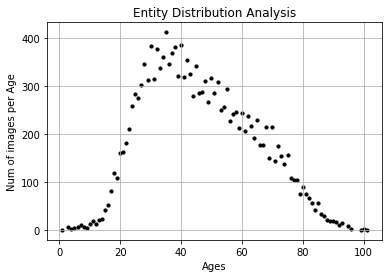

label		Age		Count
0 		 1 		 1
1 		 3 		 8
2 		 4 		 2
3 		 5 		 4
4 		 6 		 8
5 		 7 		 11
6 		 8 		 8
7 		 9 		 6
8 		 10 		 13
9 		 11 		 20
10 		 12 		 14
11 		 13 		 22
12 		 14 		 23
13 		 15 		 43
14 		 16 		 52
15 		 17 		 82
16 		 18 		 120
17 		 19 		 110
18 		 20 		 161
19 		 21 		 163
20 		 22 		 183
21 		 23 		 212
22 		 24 		 259
23 		 25 		 284
24 		 26 		 275
25 		 27 		 304
26 		 28 		 347
27 		 29 		 313
28 		 30 		 385
29 		 31 		 316
30 		 32 		 378
31 		 33 		 338
32 		 34 		 362
33 		 35 		 413
34 		 36 		 347
35 		 37 		 370
36 		 38 		 382
37 		 39 		 321
38 		 40 		 386
39 		 41 		 320
40 		 42 		 356
41 		 43 		 325
42 		 44 		 281
43 		 45 		 342
44 		 46 		 287
45 		 47 		 289
46 		 48 		 311
47 		 49 		 267
48 		 50 		 317
49 		 51 		 287
50 		 52 		 310
51 		 53 		 250
52 		 54 		 258
53 		 55 		 294
54 		 56 		 227
55 		 57 		 243
56 		 58 		 246
57 		 59 		 213
58 		 60 		 245
59 		 61 		 207
60 		 62 		 238
61 		 63 		 218
62 		 64 		 193
63 		 65 		 231

In [14]:
dataset_analysis(test_dataset)

# Dataset Loader

In [15]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [16]:
print(f"No. of Batches for AgeDB: {len(test_loader)}")

No. of Batches for AgeDB: 129


# Initialize Model, and Optimizer

In [17]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

"""Preparaing the model to evaluate on AgeDB"""
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)

print(model)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1.

# Evaluation

In [18]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [19]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

In [20]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(tqdm(data_loader)):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    probas = F.softmax(logits, dim=1)
    _, predicted_labels = torch.max(probas, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

# Testing on AgeDB

In [21]:
lists = [i for i in range(57,201)]# number epochs to evaluate
result_dict = {}

start_time = time.time()
test_mae = test_mse = test_acc = 0.0
for i in tqdm(lists):
  model_name = f'Epoch_{i}_model.pt'
  model.load_state_dict(torch.load(os.path.join(PATH, model_name)))
  model.to(DEVICE)
  model.eval()

  with torch.set_grad_enabled(False):
    str0 = f'---------------{model_name}-----------------\n'
    print(str0)
    test_mae, test_mse, test_acc = compute_mae_and_mse(model, test_loader, device=DEVICE)
    
    result_dict[model_name] = test_mae    
    str1 = f'MAE/RMSE/ACC: | AGEDB-Test: {test_mae}/{test_mse}/{test_acc}%\n'
    str = str0+str1
    print(str1)
    with open(LOGFILE, 'a') as f: f.write(f'{str}\n')
    
time_elapsed = format((time.time() - start_time)/60, ".3f")
str = f'Time elapsed: {time_elapsed}mins\n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}')

  0%|          | 0/144 [00:00<?, ?it/s]

---------------Epoch_57_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


total_num_correct_preds: 416
MAE/RMSE/ACC: | AGEDB-Test: 16.071/21.423/2.525%

---------------Epoch_58_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 362
MAE/RMSE/ACC: | AGEDB-Test: 19.499/25.966/2.197%

---------------Epoch_59_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 402
MAE/RMSE/ACC: | AGEDB-Test: 17.613/23.667/2.440%

---------------Epoch_60_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 392
MAE/RMSE/ACC: | AGEDB-Test: 16.803/22.436/2.379%

---------------Epoch_61_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 398
MAE/RMSE/ACC: | AGEDB-Test: 19.085/25.321/2.415%

---------------Epoch_62_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 354
MAE/RMSE/ACC: | AGEDB-Test: 20.599/26.677/2.148%

---------------Epoch_63_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 364
MAE/RMSE/ACC: | AGEDB-Test: 17.455/23.024/2.209%

---------------Epoch_64_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 367
MAE/RMSE/ACC: | AGEDB-Test: 17.977/24.036/2.227%

---------------Epoch_65_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 413
MAE/RMSE/ACC: | AGEDB-Test: 16.470/21.953/2.506%

---------------Epoch_66_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 391
MAE/RMSE/ACC: | AGEDB-Test: 16.111/21.403/2.373%

---------------Epoch_67_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 412
MAE/RMSE/ACC: | AGEDB-Test: 16.679/22.450/2.500%

---------------Epoch_68_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 332
MAE/RMSE/ACC: | AGEDB-Test: 19.407/25.602/2.015%

---------------Epoch_69_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 401
MAE/RMSE/ACC: | AGEDB-Test: 16.871/22.414/2.434%

---------------Epoch_70_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 347
MAE/RMSE/ACC: | AGEDB-Test: 18.182/23.807/2.106%

---------------Epoch_71_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 379
MAE/RMSE/ACC: | AGEDB-Test: 16.545/22.010/2.300%

---------------Epoch_72_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 343
MAE/RMSE/ACC: | AGEDB-Test: 19.414/25.866/2.082%

---------------Epoch_73_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 357
MAE/RMSE/ACC: | AGEDB-Test: 17.170/22.790/2.167%

---------------Epoch_74_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 426
MAE/RMSE/ACC: | AGEDB-Test: 15.899/21.437/2.585%

---------------Epoch_75_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 362
MAE/RMSE/ACC: | AGEDB-Test: 19.337/25.515/2.197%

---------------Epoch_76_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 408
MAE/RMSE/ACC: | AGEDB-Test: 16.724/22.494/2.476%

---------------Epoch_77_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 418
MAE/RMSE/ACC: | AGEDB-Test: 15.603/20.879/2.537%

---------------Epoch_78_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 357
MAE/RMSE/ACC: | AGEDB-Test: 19.811/26.128/2.167%

---------------Epoch_79_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 329
MAE/RMSE/ACC: | AGEDB-Test: 19.686/26.517/1.997%

---------------Epoch_80_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 416
MAE/RMSE/ACC: | AGEDB-Test: 16.557/22.024/2.525%

---------------Epoch_81_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 397
MAE/RMSE/ACC: | AGEDB-Test: 16.277/21.965/2.409%

---------------Epoch_82_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 329
MAE/RMSE/ACC: | AGEDB-Test: 19.072/25.263/1.997%

---------------Epoch_83_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 393
MAE/RMSE/ACC: | AGEDB-Test: 16.378/22.132/2.385%

---------------Epoch_84_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 351
MAE/RMSE/ACC: | AGEDB-Test: 20.457/27.099/2.130%

---------------Epoch_85_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 377
MAE/RMSE/ACC: | AGEDB-Test: 18.402/24.409/2.288%

---------------Epoch_86_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 379
MAE/RMSE/ACC: | AGEDB-Test: 17.776/23.804/2.300%

---------------Epoch_87_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 392
MAE/RMSE/ACC: | AGEDB-Test: 16.400/21.781/2.379%

---------------Epoch_88_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 357
MAE/RMSE/ACC: | AGEDB-Test: 18.108/23.990/2.167%

---------------Epoch_89_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 375
MAE/RMSE/ACC: | AGEDB-Test: 18.995/25.520/2.276%

---------------Epoch_90_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 326
MAE/RMSE/ACC: | AGEDB-Test: 21.991/28.766/1.978%

---------------Epoch_91_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 364
MAE/RMSE/ACC: | AGEDB-Test: 18.683/24.726/2.209%

---------------Epoch_92_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 409
MAE/RMSE/ACC: | AGEDB-Test: 16.787/22.324/2.482%

---------------Epoch_93_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 405
MAE/RMSE/ACC: | AGEDB-Test: 16.236/21.990/2.458%

---------------Epoch_94_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 368
MAE/RMSE/ACC: | AGEDB-Test: 17.738/23.359/2.233%

---------------Epoch_95_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 402
MAE/RMSE/ACC: | AGEDB-Test: 17.761/23.686/2.440%

---------------Epoch_96_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 345
MAE/RMSE/ACC: | AGEDB-Test: 18.913/24.946/2.094%

---------------Epoch_97_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 407
MAE/RMSE/ACC: | AGEDB-Test: 17.251/22.692/2.470%

---------------Epoch_98_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 315
MAE/RMSE/ACC: | AGEDB-Test: 19.933/26.128/1.912%

---------------Epoch_99_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 380
MAE/RMSE/ACC: | AGEDB-Test: 18.157/24.095/2.306%

---------------Epoch_100_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 451
MAE/RMSE/ACC: | AGEDB-Test: 15.375/20.817/2.737%

---------------Epoch_101_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 400
MAE/RMSE/ACC: | AGEDB-Test: 17.496/23.426/2.427%

---------------Epoch_102_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 385
MAE/RMSE/ACC: | AGEDB-Test: 17.371/22.966/2.336%

---------------Epoch_103_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 351
MAE/RMSE/ACC: | AGEDB-Test: 17.323/22.963/2.130%

---------------Epoch_104_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 378
MAE/RMSE/ACC: | AGEDB-Test: 16.018/21.568/2.294%

---------------Epoch_105_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 358
MAE/RMSE/ACC: | AGEDB-Test: 17.772/23.927/2.173%

---------------Epoch_106_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 382
MAE/RMSE/ACC: | AGEDB-Test: 17.749/23.324/2.318%

---------------Epoch_107_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 349
MAE/RMSE/ACC: | AGEDB-Test: 18.916/25.370/2.118%

---------------Epoch_108_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 424
MAE/RMSE/ACC: | AGEDB-Test: 15.905/21.470/2.573%

---------------Epoch_109_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 318
MAE/RMSE/ACC: | AGEDB-Test: 19.107/24.927/1.930%

---------------Epoch_110_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 378
MAE/RMSE/ACC: | AGEDB-Test: 17.283/22.842/2.294%

---------------Epoch_111_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 376
MAE/RMSE/ACC: | AGEDB-Test: 17.944/23.691/2.282%

---------------Epoch_112_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 416
MAE/RMSE/ACC: | AGEDB-Test: 16.289/21.843/2.525%

---------------Epoch_113_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 319
MAE/RMSE/ACC: | AGEDB-Test: 19.068/24.969/1.936%

---------------Epoch_114_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 311
MAE/RMSE/ACC: | AGEDB-Test: 20.999/27.084/1.887%

---------------Epoch_115_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 391
MAE/RMSE/ACC: | AGEDB-Test: 17.228/23.074/2.373%

---------------Epoch_116_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 384
MAE/RMSE/ACC: | AGEDB-Test: 17.544/23.100/2.330%

---------------Epoch_117_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 301
MAE/RMSE/ACC: | AGEDB-Test: 22.538/29.080/1.827%

---------------Epoch_118_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 395
MAE/RMSE/ACC: | AGEDB-Test: 17.066/22.530/2.397%

---------------Epoch_119_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 400
MAE/RMSE/ACC: | AGEDB-Test: 18.002/23.990/2.427%

---------------Epoch_120_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 376
MAE/RMSE/ACC: | AGEDB-Test: 16.457/21.564/2.282%

---------------Epoch_121_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 357
MAE/RMSE/ACC: | AGEDB-Test: 17.255/22.661/2.167%

---------------Epoch_122_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 368
MAE/RMSE/ACC: | AGEDB-Test: 17.680/23.215/2.233%

---------------Epoch_123_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 410
MAE/RMSE/ACC: | AGEDB-Test: 16.889/22.356/2.488%

---------------Epoch_124_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 385
MAE/RMSE/ACC: | AGEDB-Test: 16.075/21.210/2.336%

---------------Epoch_125_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 289
MAE/RMSE/ACC: | AGEDB-Test: 21.516/27.523/1.754%

---------------Epoch_126_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 352
MAE/RMSE/ACC: | AGEDB-Test: 17.181/22.534/2.136%

---------------Epoch_127_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 386
MAE/RMSE/ACC: | AGEDB-Test: 17.283/23.007/2.343%

---------------Epoch_128_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 405
MAE/RMSE/ACC: | AGEDB-Test: 16.617/22.151/2.458%

---------------Epoch_129_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 416
MAE/RMSE/ACC: | AGEDB-Test: 16.252/21.611/2.525%

---------------Epoch_130_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 390
MAE/RMSE/ACC: | AGEDB-Test: 16.563/21.807/2.367%

---------------Epoch_131_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 388
MAE/RMSE/ACC: | AGEDB-Test: 16.881/22.506/2.355%

---------------Epoch_132_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 334
MAE/RMSE/ACC: | AGEDB-Test: 19.534/25.304/2.027%

---------------Epoch_133_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 403
MAE/RMSE/ACC: | AGEDB-Test: 17.041/22.483/2.446%

---------------Epoch_134_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 360
MAE/RMSE/ACC: | AGEDB-Test: 18.248/24.441/2.185%

---------------Epoch_135_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 335
MAE/RMSE/ACC: | AGEDB-Test: 17.544/23.138/2.033%

---------------Epoch_136_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 295
MAE/RMSE/ACC: | AGEDB-Test: 21.537/28.166/1.790%

---------------Epoch_137_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 397
MAE/RMSE/ACC: | AGEDB-Test: 17.403/22.864/2.409%

---------------Epoch_138_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 382
MAE/RMSE/ACC: | AGEDB-Test: 17.611/23.321/2.318%

---------------Epoch_139_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 385
MAE/RMSE/ACC: | AGEDB-Test: 17.035/22.617/2.336%

---------------Epoch_140_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 374
MAE/RMSE/ACC: | AGEDB-Test: 17.882/23.709/2.270%

---------------Epoch_141_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 381
MAE/RMSE/ACC: | AGEDB-Test: 17.399/23.084/2.312%

---------------Epoch_142_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 391
MAE/RMSE/ACC: | AGEDB-Test: 18.352/24.455/2.373%

---------------Epoch_143_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 402
MAE/RMSE/ACC: | AGEDB-Test: 15.159/20.254/2.440%

---------------Epoch_144_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 322
MAE/RMSE/ACC: | AGEDB-Test: 19.356/25.467/1.954%

---------------Epoch_145_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 418
MAE/RMSE/ACC: | AGEDB-Test: 16.519/21.814/2.537%

---------------Epoch_146_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 380
MAE/RMSE/ACC: | AGEDB-Test: 17.982/23.752/2.306%

---------------Epoch_147_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 370
MAE/RMSE/ACC: | AGEDB-Test: 17.074/22.460/2.245%

---------------Epoch_148_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 356
MAE/RMSE/ACC: | AGEDB-Test: 17.837/23.376/2.160%

---------------Epoch_149_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 351
MAE/RMSE/ACC: | AGEDB-Test: 18.596/24.541/2.130%

---------------Epoch_150_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 383
MAE/RMSE/ACC: | AGEDB-Test: 18.742/24.950/2.324%

---------------Epoch_151_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 353
MAE/RMSE/ACC: | AGEDB-Test: 18.801/24.628/2.142%

---------------Epoch_152_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 393
MAE/RMSE/ACC: | AGEDB-Test: 17.940/23.650/2.385%

---------------Epoch_153_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 349
MAE/RMSE/ACC: | AGEDB-Test: 18.561/24.215/2.118%

---------------Epoch_154_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 392
MAE/RMSE/ACC: | AGEDB-Test: 17.886/23.705/2.379%

---------------Epoch_155_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 366
MAE/RMSE/ACC: | AGEDB-Test: 17.800/23.362/2.221%

---------------Epoch_156_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 339
MAE/RMSE/ACC: | AGEDB-Test: 18.690/24.155/2.057%

---------------Epoch_157_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 297
MAE/RMSE/ACC: | AGEDB-Test: 19.983/26.092/1.802%

---------------Epoch_158_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 319
MAE/RMSE/ACC: | AGEDB-Test: 20.738/27.021/1.936%

---------------Epoch_159_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 378
MAE/RMSE/ACC: | AGEDB-Test: 16.613/22.140/2.294%

---------------Epoch_160_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 353
MAE/RMSE/ACC: | AGEDB-Test: 19.163/25.104/2.142%

---------------Epoch_161_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 408
MAE/RMSE/ACC: | AGEDB-Test: 15.842/20.963/2.476%

---------------Epoch_162_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 386
MAE/RMSE/ACC: | AGEDB-Test: 17.194/22.835/2.343%

---------------Epoch_163_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 356
MAE/RMSE/ACC: | AGEDB-Test: 18.136/23.934/2.160%

---------------Epoch_164_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 371
MAE/RMSE/ACC: | AGEDB-Test: 18.570/24.597/2.251%

---------------Epoch_165_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 330
MAE/RMSE/ACC: | AGEDB-Test: 19.741/25.904/2.003%

---------------Epoch_166_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 355
MAE/RMSE/ACC: | AGEDB-Test: 17.133/22.481/2.154%

---------------Epoch_167_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 332
MAE/RMSE/ACC: | AGEDB-Test: 18.339/23.820/2.015%

---------------Epoch_168_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 351
MAE/RMSE/ACC: | AGEDB-Test: 18.401/24.100/2.130%

---------------Epoch_169_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 345
MAE/RMSE/ACC: | AGEDB-Test: 16.735/21.850/2.094%

---------------Epoch_170_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 396
MAE/RMSE/ACC: | AGEDB-Test: 16.548/21.818/2.403%

---------------Epoch_171_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 372
MAE/RMSE/ACC: | AGEDB-Test: 18.151/23.871/2.258%

---------------Epoch_172_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 368
MAE/RMSE/ACC: | AGEDB-Test: 18.852/24.646/2.233%

---------------Epoch_173_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 420
MAE/RMSE/ACC: | AGEDB-Test: 15.455/20.455/2.549%

---------------Epoch_174_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 418
MAE/RMSE/ACC: | AGEDB-Test: 15.724/20.912/2.537%

---------------Epoch_175_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 407
MAE/RMSE/ACC: | AGEDB-Test: 16.061/21.348/2.470%

---------------Epoch_176_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 387
MAE/RMSE/ACC: | AGEDB-Test: 17.786/23.826/2.349%

---------------Epoch_177_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 399
MAE/RMSE/ACC: | AGEDB-Test: 17.014/22.414/2.421%

---------------Epoch_178_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 415
MAE/RMSE/ACC: | AGEDB-Test: 16.761/22.374/2.519%

---------------Epoch_179_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 446
MAE/RMSE/ACC: | AGEDB-Test: 15.739/21.002/2.707%

---------------Epoch_180_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 393
MAE/RMSE/ACC: | AGEDB-Test: 17.254/22.976/2.385%

---------------Epoch_181_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 396
MAE/RMSE/ACC: | AGEDB-Test: 17.640/23.213/2.403%

---------------Epoch_182_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 388
MAE/RMSE/ACC: | AGEDB-Test: 17.512/23.266/2.355%

---------------Epoch_183_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 410
MAE/RMSE/ACC: | AGEDB-Test: 17.147/22.703/2.488%

---------------Epoch_184_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 367
MAE/RMSE/ACC: | AGEDB-Test: 17.770/23.359/2.227%

---------------Epoch_185_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 339
MAE/RMSE/ACC: | AGEDB-Test: 17.846/23.270/2.057%

---------------Epoch_186_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 316
MAE/RMSE/ACC: | AGEDB-Test: 19.824/25.527/1.918%

---------------Epoch_187_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 414
MAE/RMSE/ACC: | AGEDB-Test: 16.098/21.586/2.512%

---------------Epoch_188_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 391
MAE/RMSE/ACC: | AGEDB-Test: 15.220/20.148/2.373%

---------------Epoch_189_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 354
MAE/RMSE/ACC: | AGEDB-Test: 17.167/22.550/2.148%

---------------Epoch_190_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 385
MAE/RMSE/ACC: | AGEDB-Test: 17.054/22.462/2.336%

---------------Epoch_191_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 422
MAE/RMSE/ACC: | AGEDB-Test: 16.292/21.677/2.561%

---------------Epoch_192_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 397
MAE/RMSE/ACC: | AGEDB-Test: 16.358/21.508/2.409%

---------------Epoch_193_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 388
MAE/RMSE/ACC: | AGEDB-Test: 16.420/21.807/2.355%

---------------Epoch_194_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 368
MAE/RMSE/ACC: | AGEDB-Test: 17.852/23.729/2.233%

---------------Epoch_195_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 414
MAE/RMSE/ACC: | AGEDB-Test: 16.688/22.054/2.512%

---------------Epoch_196_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 389
MAE/RMSE/ACC: | AGEDB-Test: 17.811/23.627/2.361%

---------------Epoch_197_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 391
MAE/RMSE/ACC: | AGEDB-Test: 17.105/22.640/2.373%

---------------Epoch_198_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 402
MAE/RMSE/ACC: | AGEDB-Test: 17.106/22.610/2.440%

---------------Epoch_199_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 360
MAE/RMSE/ACC: | AGEDB-Test: 18.855/24.483/2.185%

---------------Epoch_200_model.pt-----------------



  0%|          | 0/129 [00:00<?, ?it/s]

total_num_correct_preds: 384
MAE/RMSE/ACC: | AGEDB-Test: 18.599/24.510/2.330%

Time elapsed: 154.528mins



In [22]:
result_list = sorted(result_dict.items(), key=lambda item:float(item[1]))

In [23]:
with open(LOGFILE, 'a') as f:
    f.write(f'\n\n----Result in Sorted Order----\n\n')
    for item in result_list:
        string = f'{item[0]} {item[1]}\n'
        f.write(string)
        print(string)
        f.flush()

Epoch_143_model.pt 15.159

Epoch_188_model.pt 15.220

Epoch_100_model.pt 15.375

Epoch_173_model.pt 15.455

Epoch_77_model.pt 15.603

Epoch_174_model.pt 15.724

Epoch_179_model.pt 15.739

Epoch_161_model.pt 15.842

Epoch_74_model.pt 15.899

Epoch_108_model.pt 15.905

Epoch_104_model.pt 16.018

Epoch_175_model.pt 16.061

Epoch_57_model.pt 16.071

Epoch_124_model.pt 16.075

Epoch_187_model.pt 16.098

Epoch_66_model.pt 16.111

Epoch_93_model.pt 16.236

Epoch_129_model.pt 16.252

Epoch_81_model.pt 16.277

Epoch_112_model.pt 16.289

Epoch_191_model.pt 16.292

Epoch_192_model.pt 16.358

Epoch_83_model.pt 16.378

Epoch_87_model.pt 16.400

Epoch_193_model.pt 16.420

Epoch_120_model.pt 16.457

Epoch_65_model.pt 16.470

Epoch_145_model.pt 16.519

Epoch_71_model.pt 16.545

Epoch_170_model.pt 16.548

Epoch_80_model.pt 16.557

Epoch_130_model.pt 16.563

Epoch_159_model.pt 16.613

Epoch_128_model.pt 16.617

Epoch_67_model.pt 16.679

Epoch_195_model.pt 16.688

Epoch_76_model.pt 16.724

Epoch_169_mode